## Languages Alignment

In [5]:
#import libraries
import numpy as np
import pandas as pd
import random
import gensim
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

### Read Vocabularies and Subset Bilingual Vocabularies
##### Big Files: do not run this it would take a while. 

In [2]:
# read source vocabulary (English)
source_vocabulary = KeyedVectors.load_word2vec_format('fastText/wiki.en.vec')

In [3]:
# read additional target vocabularies (Italian)
target_vocabulary = KeyedVectors.load_word2vec_format('fastText/wiki.it.vec')

In [4]:
# read additional target vocabularies (Portuguese)
target_vocabulary_1 = KeyedVectors.load_word2vec_format('fastText/wiki.pt.vec')

In [ ]:
# read additional target vocabularies (Russian)
target_vocabulary_2 = KeyedVectors.load_word2vec_format('fastText/wiki.ru.vec')

In [ ]:
# read additional target vocabularies (Japanese)
target_vocabulary_3 = KeyedVectors.load_word2vec_format('fastText/wiki.ja.vec')

In [ ]:
# read additional target vocabularies (Chinese)
target_vocabulary_4 = KeyedVectors.load_word2vec_format('fastText/wiki.zh.vec')

##### Customized_Embeddings

In [2]:
# read additional source vocabularies (trained_embeddings)
source_vocabulary_embeddings = KeyedVectors.load_word2vec_format('fastText/embeddings_vec_format/en_embeddings.vec')

In [9]:
# read additional target vocabularies (trained_embeddings)
target_vocabulary_embeddings = KeyedVectors.load_word2vec_format('fastText/embeddings_vec_format/it_embeddings.vec')

In [15]:
# Getting the tokens 
words_eng = []
for word_eng in source_vocabulary_embeddings.vocab:
    words_eng.append(word_eng)

# Printing out number of tokens available
print("Number of Tokens in English: {}".format(len(words_eng)))

# Printing out the dimension of a word vector 
print("Dimension of a word vector english embeddings: {}".format(len(source_vocabulary_embeddings[words[0]])))

words_it = []
for word_it in target_vocabulary_embeddings.vocab:
    words_it.append(word_it)

# Printing out number of tokens available
print("Number of Tokens in Italian: {}".format(len(words_it)))

# Printing out the dimension of a word vector 
print("Dimension of a word vector italian embeddings: {}".format(len(target_vocabulary_embeddings[words[0]])))

Number of Tokens in English: 192839
Dimension of a word vector english embeddings: 300
Number of Tokens in Italian: 271571
Dimension of a word vector italian embeddings: 300


In [16]:
# Dictionary to Index by Word
# EN embeddings
word_to_index_en = {}
i=0
for word, _ in source_vocabulary_embeddings.vocab.items():
    word_to_index_en[word] = i
    i=i+1
    
print(word_to_index_eng['window'])

# IT embeddings
word_to_index_it = {}
i=0
for word, _ in target_vocabulary_embeddings.vocab.items():
    word_to_index_it[word] = i
    i=i+1
    
print(word_to_index_it['finestra'])

3140
4487


In [7]:
def toy_data(source_vocabulary, target_vocabulary, n_words):
    """Function to extract bilingual vocabulary from source and target vocabularies. It returns two dictionaries (i.e. source and target languages) with same keys."""

    #create a dictionary of overlapping words
    source_words = set(source_vocabulary.index2word)
    target_words = set(target_vocabulary.index2word)
    overlap = list(source_words & target_words)
    bilingual_vocabulary = [(entry, entry) for entry in overlap]
    
    #select a random number of words from the bilingual dictionary
    pair_words = random.sample(bilingual_vocabulary, n_words)
    toy_words = [tup[0] for tup in pair_words]
    
    #store vector for each word in two dictionaries (source and target)
    source_dictionary = dict()
    target_dictionary = dict()
    for word in toy_words:
        source_dictionary[word] = source_vocabulary.get_vector(str(word))
        target_dictionary[word] = target_vocabulary.get_vector(str(word))
    
    return source_dictionary, target_dictionary

In [43]:
# generate toy data eng_pt
source_dictionary, target_dictionary = toy_data( source_vocabulary_embeddings, target_vocabulary_embeddings, 20000)

In [44]:
# check lenght
len(source_dictionary.keys()) == len(target_dictionary.keys())

True

In [45]:
len(source_dictionary.items())

20000

### Save and Load Data

In [74]:
# do not run if not needed
# Save to file
np.save('toy_data_eng-pt_100000.npy', source_dictionary)
np.save('toy_data_pt-eng_100000.npy', target_dictionary)

In [28]:
# Read from file
dictionary_eng_it = np.load('toy_data/toy_data_eng-it_20000.npy').item()
dictionary_it_eng = np.load('toy_data/toy_data_it-eng_20000.npy').item()
#check if the words are the same in the two vocabulary
dictionary_eng_it.keys() == dictionary_it_eng.keys()

True

### Split Train and Test Data

In [29]:
def split_toy_data_train_test(source_dictionary, target_dictionary, ratio_train_test):
    """Function to split source and target dictionaries in train and test. It returns train and test matrices for both source and target languages."""
    #prepare the matrix
    source_matrix = list(source_dictionary.values())
    target_matrix = list(target_dictionary.values())
    
    #select split ratio and random indices
    indices = np.random.permutation(len(source_matrix))
    ratio_train_test = ratio_train_test
    split_range = int(len(source_matrix) * ratio_train_test)
    training_idx, test_idx = indices[:split_range], indices[split_range :]

    #select by indices train and test for source and target dictionaries
    source_train = np.array([source_matrix [i] for i in training_idx])
    source_test = np.array([source_matrix[i] for i in test_idx])
    target_train = np.array([target_matrix[i] for i in training_idx])
    target_test = np.array([target_matrix[i] for i in test_idx])
    
    return source_train, source_test, target_train, target_test

In [30]:
source_train, source_test, target_train, target_test = split_toy_data_train_test(dictionary_eng_it, dictionary_it_eng, 0.7)

In [31]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(14000, 300) (6000, 300) (14000, 300) (6000, 300)


### Learn Transformation to Align Languages

In [32]:
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [33]:
def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

In [34]:
def apply_transform(transformation, source_test):
    """ Apply the given transformation to the vector space. 
    It returns predictions given transformations with embeddings E: E = E * transform """
    return np.matmul(source_test, transformation)

In [35]:
# learn the transformation
transformation = learn_transformation(source_train, target_train, normalize_vectors = True)
# apply transformation on the test of the source language
source_transformed = apply_transform(transformation, source_test)

### Evaluate Transformation

In [36]:
source_transformed.shape[0]

6000

In [37]:
def cosine_similarity(vec_a, vec_b):
    """Compute cosine similarity between vec_a and vec_b"""
    return np.dot(vec_a, vec_b) / \
        (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

In [38]:
def evaluate_proximity(source_transformed, target_test, close_neighbors, metric):
    """Compute accuracy, cosine similarity and euclidian distance between the closest transformed vectors.
    INPUT:
    close_neighbors: choose number of neighbors
    metric: 'euclidian' or 'cosine' to compute kNN neighbors
    source_tranformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    accuracy: percentage of matching words, within k neighbors, between source and target language after the alignment
    cosine_similarity: angolar distance among matching words
    l2_norm_distance: euclidian distance among matching words"""

    distance_embeddings = []
    accuracy = []
    similarity = []
    distance = []

    #fit model to find the closest vectors to tranformed one
    neighbors = NearestNeighbors(n_neighbors = close_neighbors, metric = metric)
    neighbors.fit(target_test)

    for i in range(0,source_transformed.shape[0]):
        index_transformed = i
        #distance between two vocabularies
        distance_embeddings.append(np.linalg.norm(source_transformed[i] - target_test[i]))
        #find vectors in the target vocabulary
        idx_neighbors_target = ((neighbors.kneighbors(source_transformed[index_transformed,:].reshape(1, -1)))[1][0]).tolist()
        #evaluate proximity among target and transformed vectors
        if index_transformed in idx_neighbors_target:
            accuracy.append('True')
            similarity.append(cosine_similarity(source_transformed[index_transformed], target_test[index_transformed]))
            distance.append(np.linalg.norm(source_transformed[index_transformed] - target_test[index_transformed]))
        else:
            accuracy.append('False')

    return [np.mean(distance_embeddings), round(accuracy.count('True')/len(accuracy)*100,2), np.mean(similarity), np.mean(distance)]

In [39]:
def evaluate(source_test, source_transformed, target_test):
    """Evalaute alignment comparing the source vocabulary and its transformed version with the target vocabulary.
    INPUT:
    source_test: vocabulary of the source language
    source_transformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    dictionaries evaluating the alignment with different metrics"""
    
    sources = [source_test, source_transformed]
    metrics = ['cosine', 'euclidean']
    neighbors = [1,5,10]
    evaluation_before_cosine = dict()
    evaluation_before_euclidean = dict()
    evaluation_after_cosine = dict()
    evaluation_after_euclidean = dict()

    for source in sources:
        if source[0][0] == source_test[0][0]:
            for metric in metrics:
                if metric == 'cosine':
                    for neighbor in neighbors:
                        evaluation_before_cosine[neighbor] = evaluate_proximity(source_test, target_test, neighbor, 'cosine')

                else:
                    for neighbor in neighbors:
                        evaluation_before_euclidean[neighbor] = evaluate_proximity(source_test, target_test, neighbor, 'euclidean')

        else:
            for metric in metrics:
                if metric == 'cosine':
                    for neighbor in neighbors:
                        evaluation_after_cosine[neighbor] = evaluate_proximity(source_transformed, target_test, neighbor, 'cosine')

                else:
                    for neighbor in neighbors:
                        evaluation_after_euclidean[neighbor] = evaluate_proximity(source_transformed, target_test, neighbor, 'euclidean') 

    return evaluation_before_cosine, evaluation_before_euclidean, evaluation_after_cosine, evaluation_after_euclidean

In [40]:
#evaluate alignment source target
evaluation_before_cosine, evaluation_before_euclidean, evaluation_after_cosine, evaluation_after_euclidean = evaluate(source_test, source_transformed, target_test)

In [41]:
#set alignment evaluation table
index = ['distance_embeddings', 'accuracy', 'cosine_similarity', 'euclidean_distance']

#dump evaluation within dataframe
df_eng_it = pd.DataFrame({'a': list(evaluation_before_cosine[1]),
                          'b': list(evaluation_after_cosine[1]),
                          'c': list(evaluation_before_euclidean[1]),
                          'd': list(evaluation_after_euclidean[1]),
                          
                          'e': list(evaluation_before_cosine[5]),
                          'f': list(evaluation_after_cosine[5]),
                          'g': list(evaluation_before_euclidean[5]),
                          'h': list(evaluation_after_euclidean[5]),
          
                          'i': list(evaluation_before_cosine[10]),
                          'l': list(evaluation_after_cosine[10]),
                          'm': list(evaluation_before_euclidean[10]),
                          'n': list(evaluation_after_euclidean[10])}, index=index)

#assign multilevel temporary columns name
columns=[('K@1','COSINE', 'a'),  ('K@1','COSINE', 'b'), ('K@1','EUCLIDEAN', 'c'),  ('K@1','EUCLIDEAN', 'd'),
   ('K@5','COSINE', 'e'),  ('K@5','COSINE', 'f'), ('K@5','EUCLIDEAN', 'g'),  ('K@5','EUCLIDEAN', 'h'),
    ('K@10','COSINE', 'i'),  ('K@10','COSINE', 'l'), ('K@10','EUCLIDEAN', 'm'),  ('K@10','EUCLIDEAN', 'n')]

#make multindex
df_eng_it.columns= pd.MultiIndex.from_tuples(columns)

#change columns names
change_columns_name = ['non_tranformed','tranformed','non_tranformed','tranformed', 'non_tranformed','tranformed','non_tranformed','tranformed', 'non_tranformed','tranformed','non_tranformed','tranformed']
df_eng_it.columns.set_levels(change_columns_name,level=2,inplace=True)
df_eng_it

K@1                                       \
                            COSINE                 EUCLIDEAN              
                    non_tranformed tranformed non_tranformed tranformed   
distance_embeddings       6.895148   4.370014       6.895148   4.370014   
accuracy                  0.020000  70.050000       0.020000  54.050000   
cosine_similarity         0.190715   0.632021       0.037241   0.654417   
euclidean_distance       10.064729   4.199367       6.245696   4.040536   

                               K@5                                       \
                            COSINE                 EUCLIDEAN              
                    non_tranformed tranformed non_tranformed tranformed   
distance_embeddings       6.895148   4.370014       6.895148   4.370014   
accuracy                  0.030000  84.780000       0.050000  71.830000   
cosine_similarity         0.183965   0.619390       0.050635   0.638615   
euclidean_distance       10.795370   4.258653       5.576248   4.140090   

                              K@10                                       
                            COSINE                 EUCLIDEAN             
                    non_tranformed tranformed non_tranformed tranformed  
distance_embeddings       6.895148   4.370014       6.895148   4.370014  
accuracy                  0.070000  88.930000       0.150000  77.350000  
cosine_similarity         0.167555   0.614928       0.055580   0.632310  
euclidean_distance        8.608481   4.282681       5.043834   4.177677

In [52]:
#do not run if not needed
#save evaluation table to csv
df_eng_it.to_csv('evaluation_embedding_it_eng_30k.csv')

In [32]:
#read evaluation
df = pd.read_csv('evaluation_eng_pt_20k.csv', header=[0,1,2], tupleize_cols=True)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.reset_index(drop=True)

C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\pandas\io\parsers.py:813: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


Unnamed: 0_level_0            K@1                                       \
    Unnamed: 0_level_1         COSINE                 EUCLIDEAN              
    Unnamed: 0_level_2 non_tranformed tranformed non_tranformed tranformed   
0  distance_embeddings       6.960269   4.465349       6.960269   4.465349   
1             accuracy       0.030000  60.530000       0.020000  47.520000   
2    cosine_similarity       0.192468   0.624186       0.030515   0.646520   
3   euclidean_distance       6.542164   4.264180       4.454175   4.115014   

             K@5                                                K@10  \
          COSINE                 EUCLIDEAN                    COSINE   
  non_tranformed tranformed non_tranformed tranformed non_tranformed   
0       6.960269   4.465349       6.960269   4.465349       6.960269   
1       0.120000  79.030000       0.120000  65.220000       0.130000   
2       0.171238   0.610093       0.040887   0.631336       0.162262   
3       6.249800   4.330600       5.378512   4.198347       6.335183   

                                        
                  EUCLIDEAN             
  tranformed non_tranformed tranformed  
0   4.465349       6.960269   4.465349  
1  84.550000       0.180000  71.100000  
2   0.604449       0.038368   0.624230  
3   4.354204       5.200187   4.235862

In [20]:
def evaluate_rotation(source_test, source_transformed, target_test):
    """Evalaute rotation comparing: 1) the source vocabulary and its transformed version;
                                    2) source vocabulary transformed and the target vocabulary;
                                    3) source and target vocabularies;
    INPUT:
    source_test: vocabulary of the source language
    source_transformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    euclidian distance and cosine similarity for each rotation comparison"""

    distance_source_target = []
    distance_source_transformed = []
    distance_transformed_target = []
    similarity_source_target = []
    similarity_source_transformed = []
    similarity_transformed_target = []

    for i in range(0,source_test.shape[0]):
        distance_source_target.append(np.linalg.norm(source_test[i] - target_test[i]))
        distance_source_transformed.append(np.linalg.norm(source_test[i] - source_transformed[i]))
        distance_transformed_target.append(np.linalg.norm(source_transformed[i] - target_test[i]))

        similarity_source_target.append(cosine_similarity(target_test[i],source_test[i]))
        similarity_source_transformed.append(cosine_similarity(source_test[i], source_transformed[i]))
        similarity_transformed_target.append(cosine_similarity(source_transformed[i], target_test[i]))

    return distance_source_target, distance_source_transformed, distance_transformed_target, similarity_source_target, similarity_source_transformed, similarity_transformed_target

In [21]:
# evalutate rotation
distance_source_target, distance_source_transformed, distance_transformed_target, similarity_source_target, similarity_source_transformed, similarity_transformed_target = evaluate_rotation(source_test, source_transformed, target_test)

In [42]:
# store output evaluation rotation in a dictionary
output_evaluation_rotation = {'distance_source_target':distance_source_target, 
                              'distance_source_transformed': distance_source_transformed, 
                              'distance_transformed_target': distance_transformed_target, 
                              'similarity_source_target': similarity_source_target, 
                              'similarity_source_transformed': similarity_source_transformed, 
                              'similarity_transformed_target': similarity_transformed_target}

In [43]:
#rememeber first language is the target, second the source
# save evaluation results 
import pickle
with open('output_evaluation_rotation_pt_eng', 'wb') as f:
    pickle.dump(output_evaluation_rotation, f)

In [44]:
# load evaluation results
with open('output_evaluation_rotation_eng_pt', 'rb') as f:
     data = pickle.load(f)

In [71]:
data.keys()

dict_keys(['distance_source_target', 'distance_source_transformed', 'distance_transformed_target', 'similarity_source_target', 'similarity_source_transformed', 'similarity_transformed_target'])

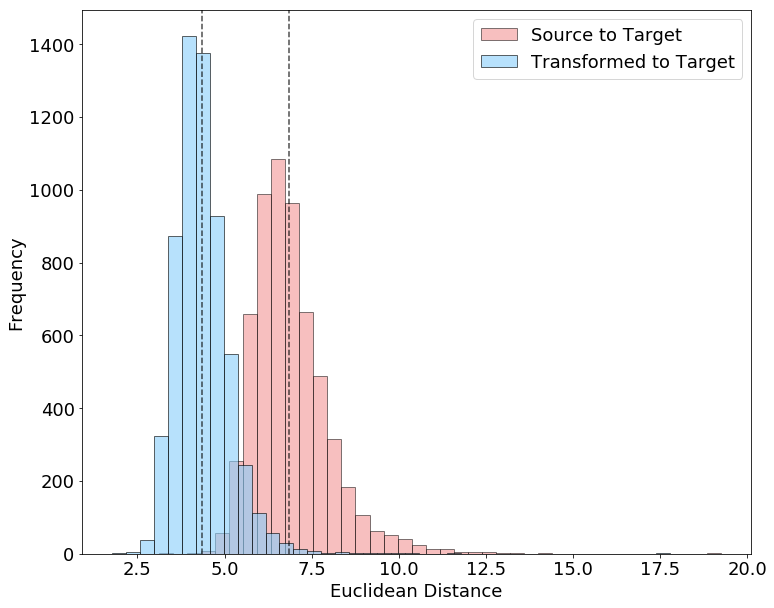

In [70]:
fig = plt.figure(figsize=(12, 10))
main_ax = fig.add_subplot(111)


main_ax.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='Source to Target')
main_ax.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='Transformed to Target')
main_ax.axvline(np.mean(distance_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(distance_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)

#main_ax.set_xticklabels(fontsize=15)
#main_ax.set_yticklabels(fontsize=15)
fs = 18

plt.xlabel('Euclidean Distance', fontsize=fs)
plt.ylabel('Frequency', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


plt.legend(loc='upper right',fontsize=fs)
#plt.figlegend(loc = 'upper right', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
#plt.suptitle('Euclidean Distance:\n before and after alignment comparisons\nEnglish-Italian', fontsize=15)
plt.savefig('Euclidean_Distance_word2vec_ENG_IT_Poster.png');

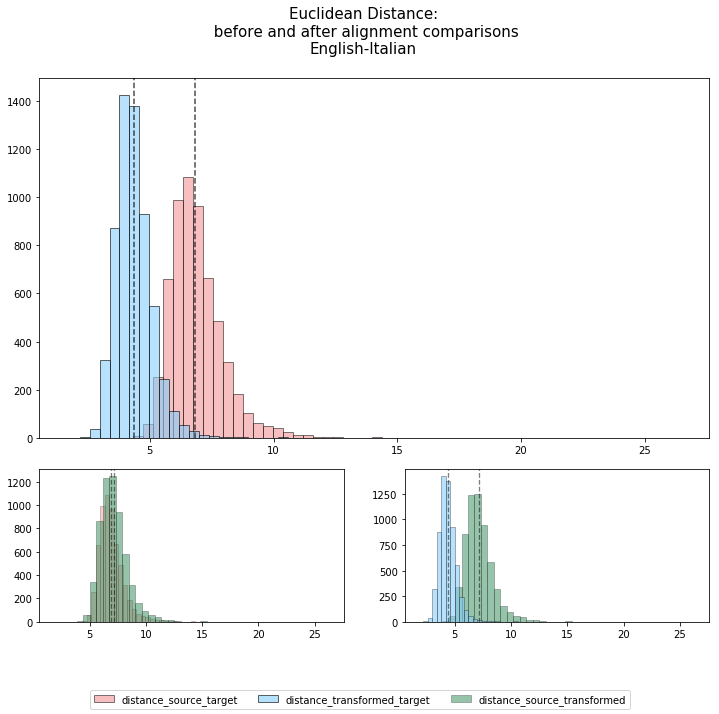

In [27]:
# Plot euclidian distances comparison pt-eng
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='distance_source_target')
main_ax.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='distance_transformed_target')
main_ax.axvline(np.mean(distance_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(distance_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

#ok
x1_hist.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='distance_source_transformed')
x1_hist.axvline(np.mean(distance_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(distance_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Euclidean Distance:\n before and after alignment comparisons\nEnglish-Italian', fontsize=15)

plt.savefig('Euclidean_Distance_Word_Embeddings_word2vec_ENG_IT_30k.png');

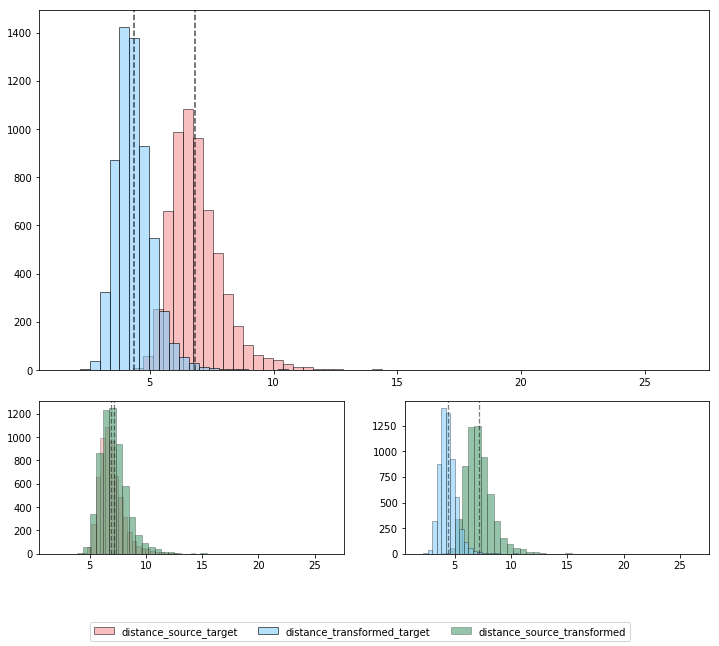

In [24]:
# Plot euclidian distances comparison eng-pt
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='distance_source_target')
main_ax.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='distance_transformed_target')
main_ax.axvline(np.mean(distance_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(distance_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

#ok
x1_hist.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='distance_source_transformed')
x1_hist.axvline(np.mean(distance_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(distance_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
#plt.suptitle('Euclidean Distance:\n before and after alignment comparisons\nEnglish-Portuguese', fontsize=15);

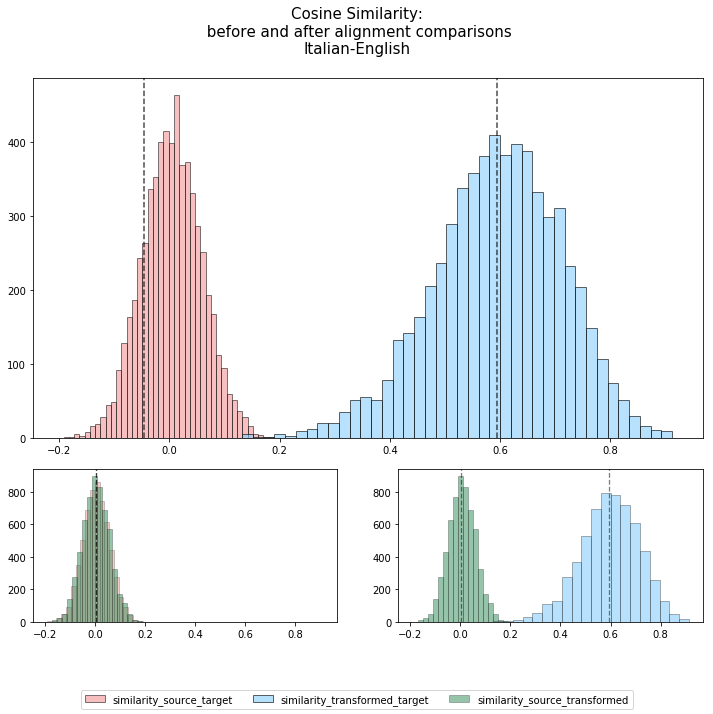

In [64]:
# Plot cosine similarities distances
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(similarity_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='similarity_source_target')
main_ax.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='similarity_transformed_target')
main_ax.axvline(np.mean(similarity_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

x1_hist.hist(similarity_source_target, 
             color = "lightcoral", bins=20, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(similarity_source_transformed, 
             color = "seagreen", bins=20, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='similarity_source_transformed')
x1_hist.axvline(np.mean(similarity_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(similarity_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(similarity_source_transformed, 
             color = "seagreen", bins=20, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=20, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(similarity_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Cosine Similarity:\n before and after alignment comparisons\nItalian-English', fontsize=15)
#plt.savefig('Cosine_Similarity_Word_Embeddings_word2vec_ENG_IT_30k.png');

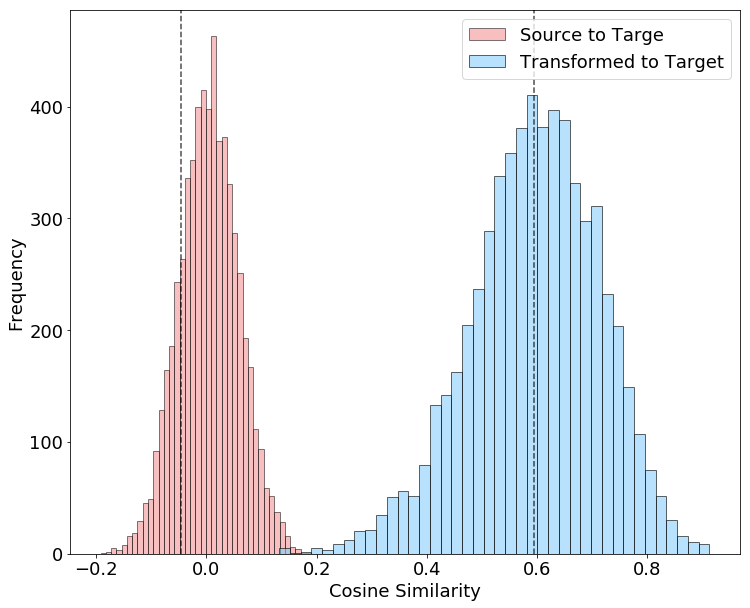

In [79]:
fig = plt.figure(figsize=(12, 10))
main_ax = fig.add_subplot(111)

main_ax.hist(similarity_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='Source to Targe')
main_ax.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='Transformed to Target')
main_ax.axvline(np.mean(similarity_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)

#main_ax.set_xticklabels(fontsize=15)
#main_ax.set_yticklabels(fontsize=15)
fs = 18

plt.xlabel('Cosine Similarity', fontsize=fs)
plt.ylabel('Frequency', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.legend(loc='upper right',fontsize=fs)
#plt.figlegend(loc = 'best', ncol=1, labelspacing=0.5,fontsize=fs) #bbox_to_anchor=(1.1, 1.05)
#plt.suptitle('Euclidean Distance:\n before and after alignment comparisons\nEnglish-Italian', fontsize=15)
plt.savefig('Cosine_Similarity_word2vec_ENG_IT_30k_Poster.png');

In [58]:
transformed_eng = apply_transform(transformation, source_vocabulary_embeddings.wv.vectors)

C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [60]:
len(transformed_eng)

192839

In [61]:
words_en = []
for word_en in source_vocabulary_embeddings.vocab:
    words_en.append(words_en)
    
vectors_en = []
for vector_en in transformed_eng:
    vectors_en.append(vector_en)

In [62]:
len(words_en) == len(vectors_en)

True

In [37]:
print(source_vocabulary_embeddings.wv.vectors[0][1])
print(vectors_en[0][1])

-0.10350573
-0.14555122


C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [34]:
len(vectors_en) == len(words_en)

True

In [65]:
#rememeber first language is the target, second the source
# save evaluation results 
import pickle
with open('en_embeddings_transformed_vectors_30k', 'wb') as f:
    pickle.dump(vectors_en, f)

In [66]:
#rememeber first language is the target, second the source
# save evaluation results 
import pickle
with open('en_embeddings_transformed_words_30k', 'wb') as f:
    pickle.dump(words_en, f)

In [35]:
en_embeddings_transformed_1 = dict(zip(words_en, vectors_en))

TypeError: unhashable type: 'list'

In [ ]:
for item in data:
    list_data_items.append(dict(zip(column_names, item)))

In [211]:
en_embeddings_transformed['the']

KeyError: 'the'

In [265]:
transformed_it = apply_transform(transformation, target_vocabulary_embeddings.wv.vectors)

C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [279]:
words_it = []
for word_it in target_vocabulary_embeddings.vocab:
    words_it.append(word_it)
    
vectors_it = []
for vector_it in transformed_it:
    vectors_it.append(vector_it)
    
it_embeddings_transformed = dict(zip(words_it, vectors_it))

In [280]:
print(target_vocabulary_embeddings.wv.vectors[0][0])
print(vectors_it[0][0])

0.1662
-0.21932493


C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [281]:
#rememeber first language is the target, second the source
# save evaluation results 
import pickle
with open('it_embeddings_transformed_30k', 'wb') as f:
    pickle.dump(it_embeddings_transformed, f)

In [282]:
# load evaluation results
import pickle
with open('it_embeddings_transformed_30k', 'rb') as f:
     data = pickle.load(f)

In [283]:
data['finestra']

array([ 1.04102574e-01,  8.53906795e-02,  3.45262438e-02,  3.08958471e-01,
       -4.55358744e-01,  9.56388842e-03, -7.11855888e-02,  2.92564601e-01,
       -4.74088252e-01, -3.40269387e-01,  3.02566826e-01,  2.47570261e-01,
       -2.48926014e-01,  2.07503423e-01, -2.64416188e-02, -1.11246541e-01,
       -5.19126356e-02,  2.74203241e-01, -7.82587156e-02,  2.04802498e-01,
        2.02822313e-01,  5.86275995e-01, -3.59621674e-01,  6.37516007e-02,
        2.61027336e-01, -1.72196269e-01, -2.45261088e-01, -2.35349014e-02,
        2.46487811e-01, -2.42614225e-01,  1.33795530e-01,  5.57418354e-02,
       -5.00054955e-02, -6.58498332e-02, -5.71177006e-02, -9.41673368e-02,
        1.18887372e-01,  5.69146514e-01, -3.19544107e-01,  1.28659699e-02,
       -1.80692241e-01,  3.82852443e-02,  1.78347100e-02, -2.52661735e-01,
       -8.12189132e-02, -7.59331584e-02, -1.25134990e-01, -1.97325453e-01,
       -4.85549301e-01,  5.80631904e-02,  2.99380779e-01, -5.09750009e-01,
        1.05595440e-01, -

In [121]:
from gensim.models import Word2Vec

In [122]:
model= Word2Vec()
model.build_vocab_from_freq(it_embeddings_transformed)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
save_word2vec_format(fname, prefix='*dt_', fvocab=None, total_vec=None, binary=False, write_first_line=True)¶
Store the input-hidden weight matrix in the same format used by the original C word2vec-tool, for compatibility.

Parameters:	
fname (str) – The file path used to save the vectors in.
prefix (str) – Uniquely identifies doctags from word vocab, and avoids collision in case of repeated string in doctag and word vocab.
fvocab (str) – Optional file path used to save the vocabulary
binary (bool) – If True, the data wil be saved in binary word2vec format, else it will be saved in plain text.
total_vec (int) – Optional parameter to explicitly specify total no. of vectors (in case word vectors are appended with document vectors afterwards)
write_first_line (bool) – Whether to print the first line in the file. Useful when saving doc-vectors after word-vectors.

In [ ]:
save_word2vec_format(fname, fvocab=None, binary=False, total_vec=None)
Store the input-hidden weight matrix in the same format used by the original C word2vec-tool, for compatibility.

Parameters:	
fname (str) – The file path used to save the vectors in.
fvocab (str) – Optional file path used to save the vocabulary.
binary (bool) – If True, the data wil be saved in binary word2vec format, else it will be saved in plain text.
total_vec (int) – Optional parameter to explicitly specify total no. of vectors (in case word vectors are appended with document vectors afterwards).

### Plot t-sne (2D)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Limit number of tokens to be visualized
limit = 150
vector_dim = 300

# Getting tokens and vectors
words = []
embedding = np.array([])
i = 0
for word in it_dictionary.vocab:
    # Break the loop if limit exceeds 
    if i == limit: break

    # Getting token 
    words.append(word)

    # Appending the vectors 
    embedding = np.append(embedding, it_dictionary[word])

    i += 1

# Reshaping the embedding vector 
embedding = embedding.reshape(limit, vector_dim)


def plot_with_labels(low_dim_embs, labels, filename='it_dictionary_tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)


# Creating the tsne plot
tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)

In [ ]:
# Limit number of tokens to be visualized
limit = 500
vector_dim = 300

# Getting tokens and vectors
words = []
embedding = np.array([])
i = 0
for word in eng_dictionary.vocab:
    # Break the loop if limit exceeds 
    if i == limit: break

    # Getting token 
    words.append(word)

    # Appending the vectors 
    embedding = np.append(embedding, eng_dictionary[word])

    i += 1

# Reshaping the embedding vector 
embedding = embedding.reshape(limit, vector_dim)

def plot_with_labels(low_dim_embs, labels, filename='eng_dictionary_tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)

# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='it_dictionary_tsne_3d.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y, z = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)


# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=30.0, n_components=3, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)